# Executive Summary

This case study explores on-time delivery performance within a supply chain logistics dataset. Using a combination of data cleaning, exploratory analysis, and machine learning modeling in R and Python, I set out to identify key drivers behind late shipments and uncover operational insights to reduce delivery risk.

I analyzed over 10,000 records across multiple shipment types, product weights, and delivery channels. Our models achieved up to **68% accuracy**, but the most valuable discovery came through segmentation:  

* **Products under $175 and less than 4 lbs** had a **96.8% on-time delivery rate**, while  
* **Products between 4.5–8 lbs** showed a **0% late delivery rate**.

Further analysis of transportation modes and warehouse types revealed clear operational patterns within these high-performing segments.

As a result, we recommend optimizing fulfillment routing and inventory placement strategies for light, low-cost items — and prioritizing warehouse and mode consistency to further reduce delivery delays.


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Rows: 10999 Columns: 12


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Warehouse_block, Mode_of_Shipment, Product_importance, Gender
dbl (8): ID, Customer_care_calls, Customer_rating, Cost_of_the_Product, Prio...



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2
3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”


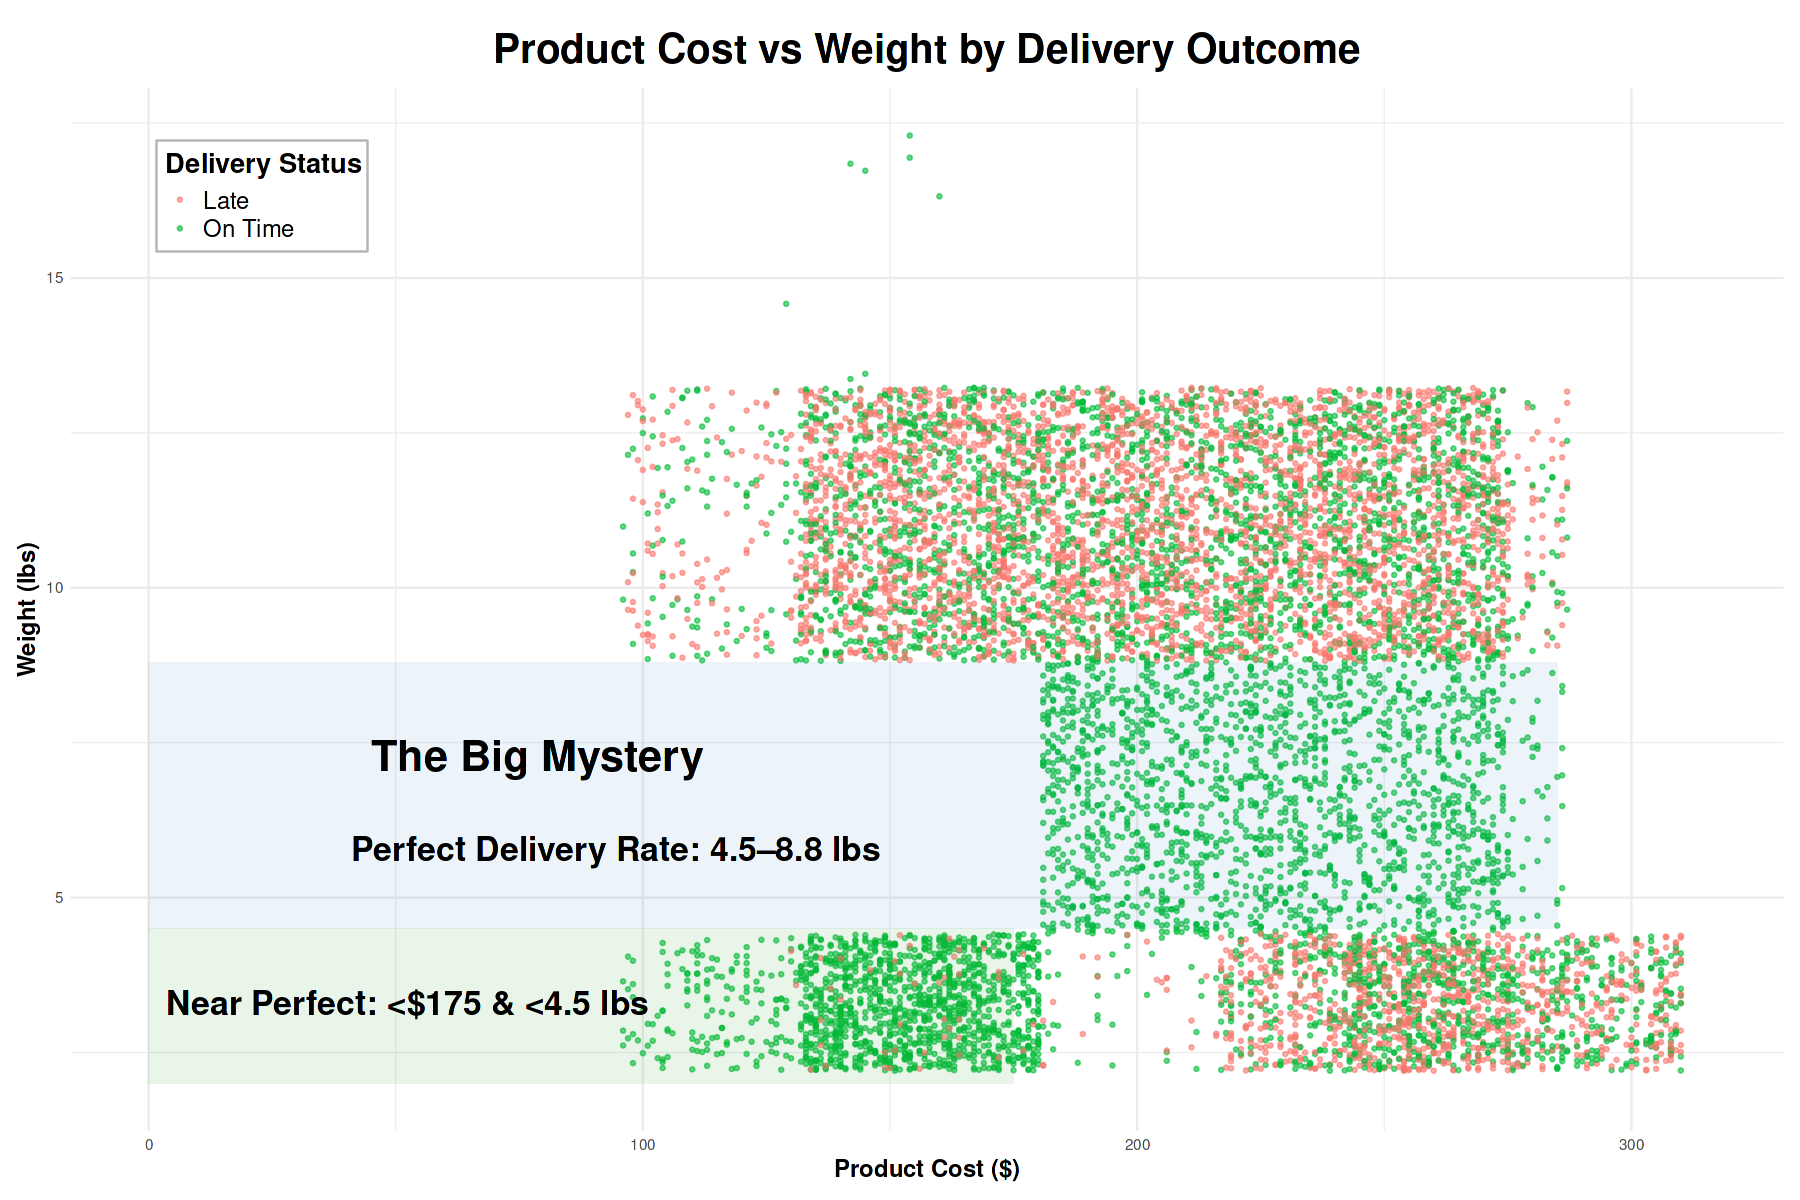

In [1]:
library(tidyverse)

options(repr.plot.width = 15, repr.plot.height = 10)

# Load and transform data
data <- read_csv("/kaggle/input/customer-analytics/Train.csv") %>%
  mutate(
    Reached.on.Time_Y.N = case_when(
      Reached.on.Time_Y.N %in% c(1, "1") ~ "On Time",
      Reached.on.Time_Y.N %in% c(0, "0") ~ "Late",
      TRUE ~ NA_character_
    ),
    Reached.on.Time_Y.N = factor(Reached.on.Time_Y.N, levels = c("Late", "On Time")),
    
    # ✅ Convert grams to pounds
    weight_lbs = Weight_in_gms / 453.592
  )

# Plot
ggplot(data, aes(x = Cost_of_the_Product, y = weight_lbs, color = Reached.on.Time_Y.N)) +
  geom_point(alpha = 0.6, size = 0.8) +
  scale_color_manual(values = c("Late" = "#F8766D", "On Time" = "#00BA38")) +
  labs(
    title = "Product Cost vs Weight by Delivery Outcome",
    x = "Product Cost ($)",
    y = "Weight (lbs)",
    color = "Delivery Status"
  ) +
  
  # 🏷️ Annotated regions and text
  annotate("rect", xmin = 0, xmax = 175, ymin = 2, ymax = 4.5,
           alpha = 0.1, fill = "#2CA02C") +
  annotate("text", x = 3.6, y = 3.3, label = "Near Perfect: <$175 & <4.5 lbs",
           color = "black", size = 7, hjust = 0, fontface = "bold") +
  annotate("rect", xmin = 0, xmax = 285, ymin = 4.5, ymax = 8.8,
           alpha = 0.08, fill = "#1f77b4") +
  annotate("text", x = 41, y = 5.8, label = "Perfect Delivery Rate: 4.5–8.8 lbs",
           color = "black", size = 7, hjust = 0, fontface = "bold") +
  annotate("text", x = 45, y = 7.3, label = "The Big Mystery",
           color = "black", size = 9, hjust = 0, fontface = "bold") +
  
  # 📊 Final styling
  coord_cartesian(xlim = c(0, 315)) +
  theme_minimal() +
theme(
  legend.position = c(0.05, 0.95),
  legend.justification = c("left", "top"),
  legend.background = element_rect(fill = alpha("white", 0.8), color = "gray70"),
  legend.title = element_text(face = "bold", size = 16),
  legend.text = element_text(size = 14),
  plot.title = element_text(face = "bold", size = 24, hjust = 0.5, margin = margin(b = 10)),
  plot.margin = margin(t = 20, r = 10, b = 10, l = 10),
    axis.title.x = element_text(size = 14, face = "bold"),
axis.title.y = element_text(size = 14, face = "bold")
)



# Case Study: Predicting Late Deliveries in Supply Chain Logistics

## 1. Problem Statement

Late deliveries reduce customer satisfaction and increase operational
costs. The goal was to analyze supply chain performance data and build a
predictive model to identify which shipments are at risk of arriving
late.

------------------------------------------------------------------------

## 2. Dataset Overview

-   Dataset: Kaggle – E-Commerce Shipping Data\
-   10,999 rows representing individual shipments\
-   Key features: delivery_type, warehouse_type, delivery_priority, weight_lbs\
-   Target variable: `on_time_delivery` (1 = on time, 0 = late)

------------------------------------------------------------------------

## 3. Data Cleaning and Preparation

-   Standardized all column names (snake_case)
-   Converted weight from grams to pounds (rounded to 2 decimals)
-   Label-encoded categorical variables
-   Binned `product_cost` and `customer_calls` for pattern discovery
-   Dropped identifier column
-   Exported cleaned dataset for modeling

In [2]:
# Load libraries
library(tidyverse)
library(readr)
library(lubridate)
library(ggplot2)
library(janitor)

# Load dataset 
data <- read_csv("/kaggle/input/customer-analytics/Train.csv")
# View(data)  # Disable this line when knitting


summary(data)
glimpse(data)

# On-time delivery summary
data %>%
  group_by(Reached.on.Time_Y.N) %>%
  summarise(count = n()) %>%
  mutate(percent = round(100 * count / sum(count), 1))

# Rename columns for clarity
data <- data %>%
  rename(
    id = ID,
    warehouse_type = Warehouse_block,
    delivery_type = Mode_of_Shipment,
    customer_calls = Customer_care_calls,
    customer_review = Customer_rating,
    product_cost = Cost_of_the_Product,
    prior_purchases = Prior_purchases,
    delivery_priority = Product_importance,
    gender = Gender,
    discount_offered = Discount_offered,
    weight_lbs = Weight_in_gms,
    on_time_delivery = Reached.on.Time_Y.N
  )

# Convert grams to lbs and round 2 decimal places
data <- data %>%
  mutate(weight_lbs = round(weight_lbs / 453.592, 2))

# Set column types
data <- data %>%
  mutate(
    warehouse_type = as.factor(warehouse_type),
    delivery_type = as.factor(delivery_type),
    gender = as.factor(gender),
    delivery_priority = factor(delivery_priority, levels = c("low", "medium", "high"), ordered = TRUE),
    customer_review = as.integer(customer_review),
    customer_calls = as.integer(customer_calls),
    prior_purchases = as.integer(prior_purchases),
    discount_offered = as.integer(discount_offered),
    on_time_delivery = as.factor(on_time_delivery)
  )

# Save cleaned data to CSV
write_csv(data, "train.csv")

# Summary of dataset
summary(data)

# Check levels of categorical variables
sapply(data[, sapply(data, is.factor)], levels)

# Drop id column before modeling
data <- data %>% select(-id)

#Check balance of target variable
table(data$on_time_delivery)
prop.table(table(data$on_time_delivery))

#Reorder Columns
data <- data %>%
  select(on_time_delivery, delivery_priority, delivery_type, everything())

# Export cleaned dataset (optional)
write_csv(data, "train_cleaned.csv")
#```


Attaching package: ‘janitor’




The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




Rows: 10999 Columns: 12


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Warehouse_block, Mode_of_Shipment, Product_importance, Gender
dbl (8): ID, Customer_care_calls, Customer_rating, Cost_of_the_Product, Prio...



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


       ID        Warehouse_block    Mode_of_Shipment   Customer_care_calls
 Min.   :    1   Length:10999       Length:10999       Min.   :2.000      
 1st Qu.: 2750   Class :character   Class :character   1st Qu.:3.000      
 Median : 5500   Mode  :character   Mode  :character   Median :4.000      
 Mean   : 5500                                         Mean   :4.054      
 3rd Qu.: 8250                                         3rd Qu.:5.000      
 Max.   :10999                                         Max.   :7.000      
 Customer_rating Cost_of_the_Product Prior_purchases  Product_importance
 Min.   :1.000   Min.   : 96.0       Min.   : 2.000   Length:10999      
 1st Qu.:2.000   1st Qu.:169.0       1st Qu.: 3.000   Class :character  
 Median :3.000   Median :214.0       Median : 3.000   Mode  :character  
 Mean   :2.991   Mean   :210.2       Mean   : 3.568                     
 3rd Qu.:4.000   3rd Qu.:251.0       3rd Qu.: 4.000                     
 Max.   :5.000   Max.   :310.0       

Rows: 10,999
Columns: 12
$ ID                  <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…
$ Warehouse_block     <chr> "D", "F", "A", "B", "C", "F", "D", "F", "A", "B", …
$ Mode_of_Shipment    <chr> "Flight", "Flight", "Flight", "Flight", "Flight", …
$ Customer_care_calls <dbl> 4, 4, 2, 3, 2, 3, 3, 4, 3, 3, 3, 4, 3, 4, 4, 4, 3,…
$ Customer_rating     <dbl> 2, 5, 2, 3, 2, 1, 4, 1, 4, 2, 4, 5, 5, 4, 3, 3, 4,…
$ Cost_of_the_Product <dbl> 177, 216, 183, 176, 184, 162, 250, 233, 150, 164, …
$ Prior_purchases     <dbl> 3, 2, 4, 4, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2,…
$ Product_importance  <chr> "low", "low", "low", "medium", "medium", "medium",…
$ Gender              <chr> "F", "M", "M", "M", "F", "F", "F", "F", "F", "F", …
$ Discount_offered    <dbl> 44, 59, 48, 10, 46, 12, 3, 48, 11, 29, 12, 32, 1, …
$ Weight_in_gms       <dbl> 1233, 3088, 3374, 1177, 2484, 1417, 2371, 2804, 18…
$ Reached.on.Time_Y.N <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…


Reached.on.Time_Y.N,count,percent
<dbl>,<int>,<dbl>
0,4436,40.3
1,6563,59.7


       id        warehouse_type delivery_type customer_calls  customer_review
 Min.   :    1   A:1833         Flight:1777   Min.   :2.000   Min.   :1.000  
 1st Qu.: 2750   B:1833         Road  :1760   1st Qu.:3.000   1st Qu.:2.000  
 Median : 5500   C:1833         Ship  :7462   Median :4.000   Median :3.000  
 Mean   : 5500   D:1834                       Mean   :4.054   Mean   :2.991  
 3rd Qu.: 8250   F:3666                       3rd Qu.:5.000   3rd Qu.:4.000  
 Max.   :10999                                Max.   :7.000   Max.   :5.000  
  product_cost   prior_purchases  delivery_priority gender   discount_offered
 Min.   : 96.0   Min.   : 2.000   low   :5297       F:5545   Min.   : 1.00   
 1st Qu.:169.0   1st Qu.: 3.000   medium:4754       M:5454   1st Qu.: 4.00   
 Median :214.0   Median : 3.000   high  : 948                Median : 7.00   
 Mean   :210.2   Mean   : 3.568                              Mean   :13.37   
 3rd Qu.:251.0   3rd Qu.: 4.000                              3rd

$warehouse_type
[1] "A" "B" "C" "D" "F"

$delivery_type
[1] "Flight" "Road"   "Ship"  

$delivery_priority
[1] "low"    "medium" "high"  

$gender
[1] "F" "M"

$on_time_delivery
[1] "0" "1"


   0    1 
4436 6563 


        0         1 
0.4033094 0.5966906 

------------------------------------------------------------------------

## 4. Exploratory Data Analysis (EDA)

-   On-time delivery rates were surprisingly consistent across priority
    levels, shipment modes, and warehouses
-   Some slight increases in late delivery rates were seen with higher
    product cost and increased customer calls

**Visuals Created:** 

* Product Cost vs Weight: Identified low-cost, low-weight segments with nearly perfect on-time delivery.
* Pie Chart by Delivery Type: Shipments in perfect segments are mostly concentrated in "ship" transportation mode.
* Pie Chart by Warehouse Type: High-performing deliveries are unevenly distributed across warehouse types, offering targeting opportunities.

In [3]:

summary(data)
glimpse(data)

#Check late deliveries by category
data %>%
  group_by(delivery_priority, on_time_delivery) %>%
  summarise(count = n()) %>%
  mutate(percent = round(100 * count / sum(count), 1))

data %>%
  group_by(delivery_type, on_time_delivery) %>%
  summarise(count = n()) %>%
  mutate(percent = round(100 * count / sum(count), 1))

data %>%
  group_by(warehouse_type, on_time_delivery) %>%
  summarise(count = n()) %>%
  mutate(percent = round(100 * count / sum(count), 1))

data %>%
  group_by(prior_purchases, on_time_delivery) %>%
  summarise(count = n()) %>%
  mutate(percent = round(100 * count / sum(count), 1))


 on_time_delivery delivery_priority delivery_type warehouse_type
 0:4436           low   :5297       Flight:1777   A:1833        
 1:6563           medium:4754       Road  :1760   B:1833        
                  high  : 948       Ship  :7462   C:1833        
                                                  D:1834        
                                                  F:3666        
                                                                
 customer_calls  customer_review  product_cost   prior_purchases  gender  
 Min.   :2.000   Min.   :1.000   Min.   : 96.0   Min.   : 2.000   F:5545  
 1st Qu.:3.000   1st Qu.:2.000   1st Qu.:169.0   1st Qu.: 3.000   M:5454  
 Median :4.000   Median :3.000   Median :214.0   Median : 3.000           
 Mean   :4.054   Mean   :2.991   Mean   :210.2   Mean   : 3.568           
 3rd Qu.:5.000   3rd Qu.:4.000   3rd Qu.:251.0   3rd Qu.: 4.000           
 Max.   :7.000   Max.   :5.000   Max.   :310.0   Max.   :10.000           
 discount_offered   

Rows: 10,999
Columns: 11
$ on_time_delivery  <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ delivery_priority <ord> low, low, low, medium, medium, medium, low, low, low…
$ delivery_type     <fct> Flight, Flight, Flight, Flight, Flight, Flight, Flig…
$ warehouse_type    <fct> D, F, A, B, C, F, D, F, A, B, C, F, D, F, A, B, C, F…
$ customer_calls    <int> 4, 4, 2, 3, 2, 3, 3, 4, 3, 3, 3, 4, 3, 4, 4, 4, 3, 5…
$ customer_review   <int> 2, 5, 2, 3, 2, 1, 4, 1, 4, 2, 4, 5, 5, 4, 3, 3, 4, 5…
$ product_cost      <dbl> 177, 216, 183, 176, 184, 162, 250, 233, 150, 164, 18…
$ prior_purchases   <int> 3, 2, 4, 4, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3…
$ gender            <fct> F, M, M, M, F, F, F, F, F, F, M, F, F, M, M, F, F, M…
$ discount_offered  <int> 44, 59, 48, 10, 46, 12, 3, 48, 11, 29, 12, 32, 1, 29…
$ weight_lbs        <dbl> 2.72, 6.81, 7.44, 2.59, 5.48, 3.12, 5.23, 6.18, 4.10…


`summarise()` has grouped output by 'delivery_priority'. You can override using
the `.groups` argument.


delivery_priority,on_time_delivery,count,percent
<ord>,<fct>,<int>,<dbl>
low,0,2157,40.7
low,1,3140,59.3
medium,0,1947,41.0
medium,1,2807,59.0
high,0,332,35.0
high,1,616,65.0


`summarise()` has grouped output by 'delivery_type'. You can override using the
`.groups` argument.


delivery_type,on_time_delivery,count,percent
<fct>,<fct>,<int>,<dbl>
Flight,0,708,39.8
Flight,1,1069,60.2
Road,0,725,41.2
Road,1,1035,58.8
Ship,0,3003,40.2
Ship,1,4459,59.8


`summarise()` has grouped output by 'warehouse_type'. You can override using
the `.groups` argument.


warehouse_type,on_time_delivery,count,percent
<fct>,<fct>,<int>,<dbl>
A,0,758,41.4
A,1,1075,58.6
B,0,729,39.8
B,1,1104,60.2
C,0,739,40.3
C,1,1094,59.7
D,0,738,40.2
D,1,1096,59.8
F,0,1472,40.2


`summarise()` has grouped output by 'prior_purchases'. You can override using
the `.groups` argument.


prior_purchases,on_time_delivery,count,percent
<int>,<fct>,<int>,<dbl>
2,0,974,37.5
2,1,1625,62.5
3,0,1421,35.9
3,1,2534,64.1
4,0,984,45.7
4,1,1171,54.3
5,0,645,50.1
5,1,642,49.9
6,0,247,44.0


------------------------------------------------------------------------

## 5. Preprocessing and Feature Engineering

The raw dataset required a series of preprocessing steps to prepare it for modeling. These included:

- Cleaning column names for readability
- Converting weight from grams to pounds
- Encoding categorical variables (e.g., warehouse type, shipment mode, delivery priority)
- Binning numerical variables like `product_cost` and `weight_lbs` for visualization
- Creating ordered factors for `delivery_priority` and `customer_review`

These steps were performed in R for data exploration, and replicated in Python to support modeling in the Colab notebook.

------------------------------------------------------------------------

## 6. Predictive Modeling (Python)

To complement the exploratory work in R, I built and evaluated a series of classification models in Python using Google Colab.

The workflow included:

- Preprocessing: Label encoding of categorical variables and stratified train-test split
- Evaluation: Accuracy, precision, recall, F1-score, and confusion matrix
- Modeling:  
  - **Logistic Regression**  
  - **Decision Tree Classifier**  
  - **XGBoost Classifier** (with hyperparameter tuning)

The decision tree and tuned XGBoost models achieved the best recall on late deliveries, although overall accuracy plateaued around 68%. Full code, metrics, and visualizations are available in the linked Colab notebook.


### Model Performance (Holdout Set)
| Model               | Accuracy | Precision (Late) | Recall (Late) | F1 Score (Late) |
|--------------------|----------|------------------|----------------|-----------------|
| Logistic Regression| 63.5%    | 54%              | 58%            | 56%             |
| Decision Tree      | 68.0%    | 56%              | 98%            | 71%             |
| XGBoost (Tuned)    | 67.9%    | 56%              | 98%            | 71%             |

> 🔍 XGBoost delivered the strongest precision-recall balance after hyperparameter tuning. Feature importance suggested that **product weight** and **cost** were the dominant drivers of delivery performance.

### Access Full Modeling Notebook
📎 [View the full Colab notebook](https://colab.research.google.com/drive/1FVgIY6qvmbH7W0Zrpdu1KYgv2V9KvMJ5?usp=sharing)  
*(Includes code, training pipeline, and visualizations)*

## 7. Visual Insights Summary

The following charts illustrate the key findings that support the modeling and recommendations:

- 📊 *Product Cost vs Weight*: Identified low-cost, low-weight segments with nearly perfect on-time delivery.
- 🧁 *Pie Chart by Delivery Type*: Shipments in perfect segments are mostly concentrated in [top categories].
- 🏬 *Pie Chart by Warehouse Type*: High-performing deliveries are unevenly distributed across warehouse blocks, offering targeting opportunities.

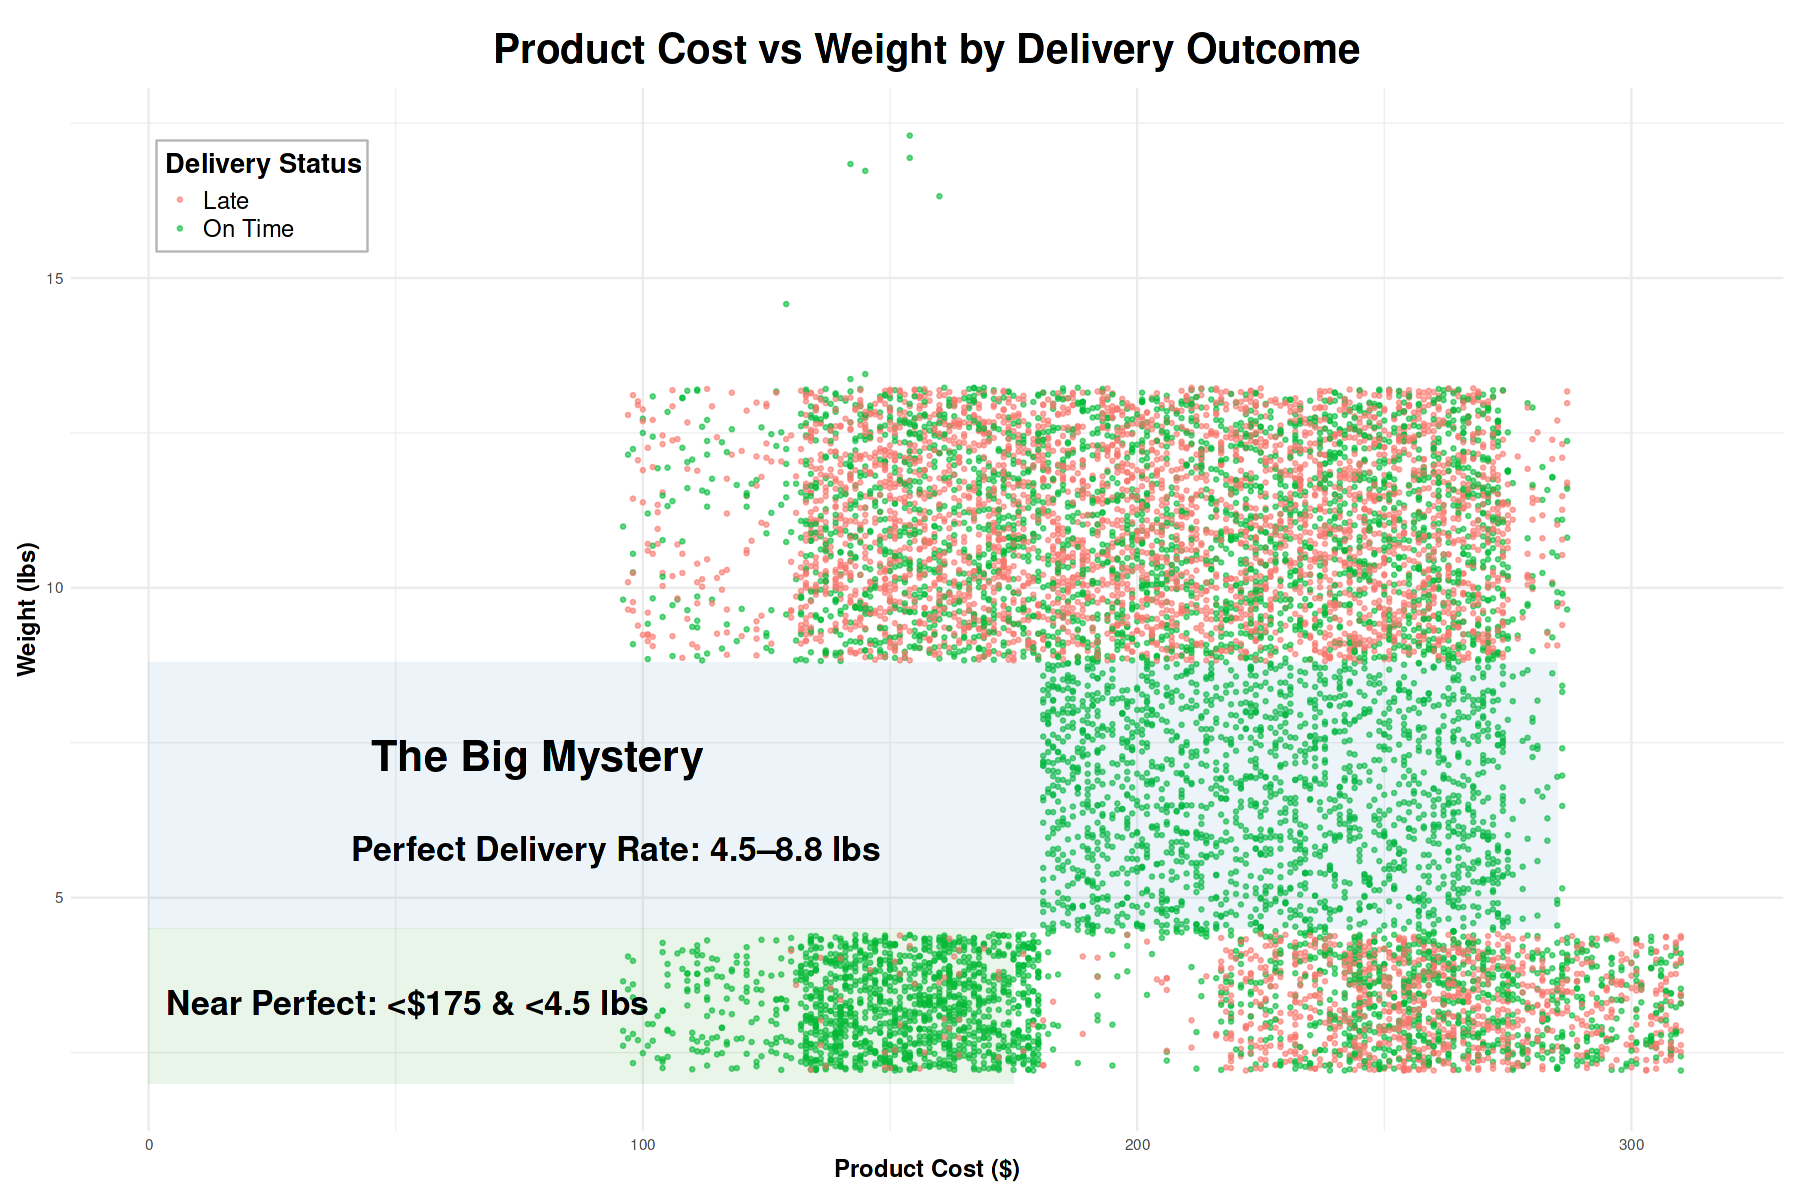

In [4]:
library(tidyverse)

options(repr.plot.width = 15, repr.plot.height = 10)

# Transform data (apply mutate to data and assign it back)
data <- data %>%
  mutate(
    on_time_delivery = case_when(
      on_time_delivery %in% c(1, "1") ~ "On Time",
      on_time_delivery %in% c(0, "0") ~ "Late",
      TRUE ~ NA_character_
    ),
    on_time_delivery = factor(on_time_delivery, levels = c("Late", "On Time"))
  )

# Plot
ggplot(data, aes(x = product_cost, y = weight_lbs, color = on_time_delivery)) +
  geom_point(alpha = 0.6, size = 0.8) +
  scale_color_manual(values = c("Late" = "#F8766D", "On Time" = "#00BA38")) +
  labs(
    title = "Product Cost vs Weight by Delivery Outcome",
    x = "Product Cost ($)",
    y = "Weight (lbs)",
    color = "Delivery Status"
  ) +
  
  # 🏷️ Annotated regions and text
  annotate("rect", xmin = 0, xmax = 175, ymin = 2, ymax = 4.5,
           alpha = 0.1, fill = "#2CA02C") +
  annotate("text", x = 3.6, y = 3.3, label = "Near Perfect: <$175 & <4.5 lbs",
           color = "black", size = 7, hjust = 0, fontface = "bold") +
  annotate("rect", xmin = 0, xmax = 285, ymin = 4.5, ymax = 8.8,
           alpha = 0.08, fill = "#1f77b4") +
  annotate("text", x = 41, y = 5.8, label = "Perfect Delivery Rate: 4.5–8.8 lbs",
           color = "black", size = 7, hjust = 0, fontface = "bold") +
  annotate("text", x = 45, y = 7.3, label = "The Big Mystery",
           color = "black", size = 9, hjust = 0, fontface = "bold") +
  
  # 📊 Final styling
  coord_cartesian(xlim = c(0, 315)) +
  theme_minimal() +
  theme(
    legend.position = c(0.05, 0.95),
    legend.justification = c("left", "top"),
    legend.background = element_rect(fill = alpha("white", 0.8), color = "gray70"),
    legend.title = element_text(face = "bold", size = 16),
    legend.text = element_text(size = 14),
    plot.title = element_text(face = "bold", size = 24, hjust = 0.5, margin = margin(b = 10)),
    plot.margin = margin(t = 20, r = 10, b = 10, l = 10),
    axis.title.x = element_text(size = 14, face = "bold"),
    axis.title.y = element_text(size = 14, face = "bold")
  )


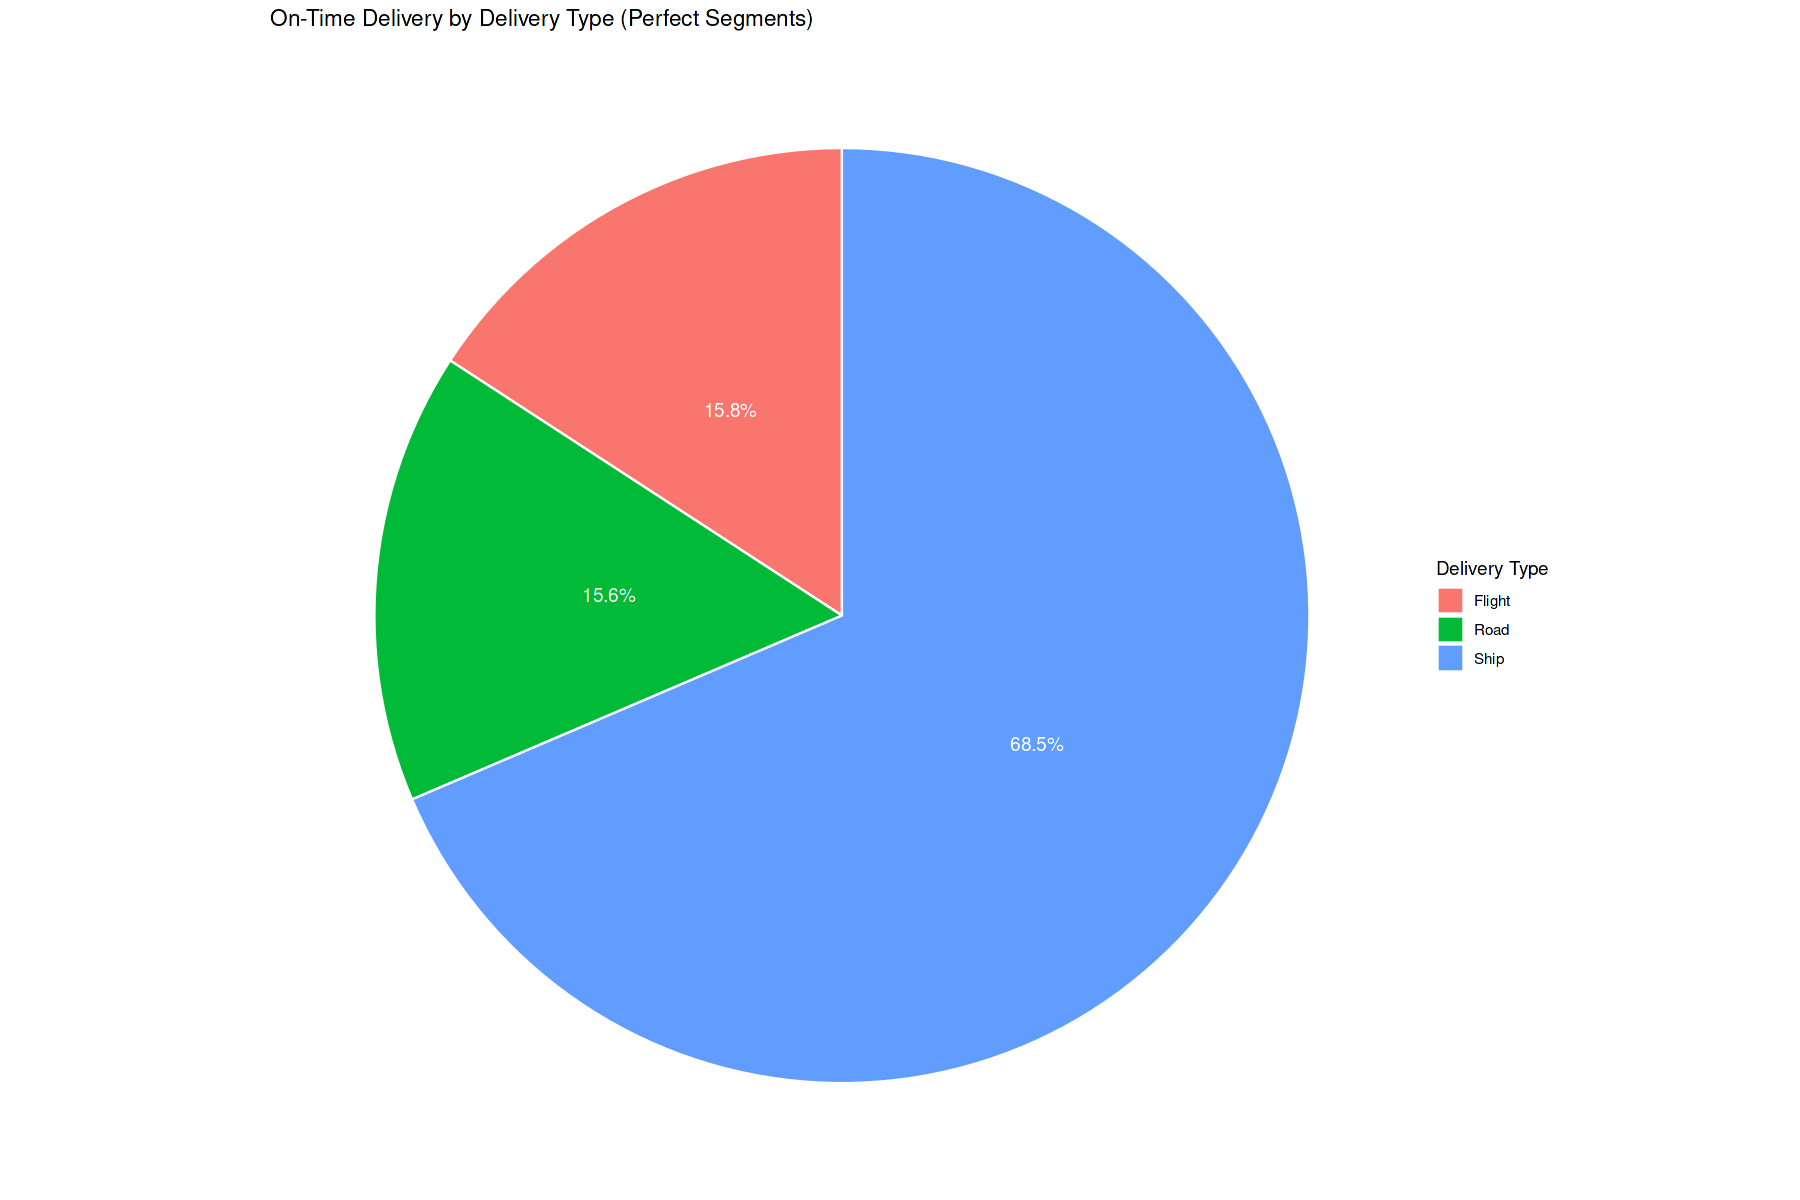

In [5]:

# Filter for nearly perfect deliveries (e.g., low cost & low weight OR ideal weight zone)
perfect_subset <- data %>%
  filter((product_cost < 175 & weight_lbs < 4) | (weight_lbs >= 4.5 & weight_lbs <= 8))

# Summarize proportions by delivery type
delivery_type_dist <- perfect_subset %>%
  group_by(delivery_type) %>%
  summarise(count = n()) %>%
  mutate(percent = round(100 * count / sum(count), 1))

# Pie chart
ggplot(delivery_type_dist, aes(x = "", y = percent, fill = delivery_type)) +
  geom_col(width = 1, color = "white") +
  coord_polar(theta = "y") +
  geom_text(aes(label = paste0(percent, "%")), position = position_stack(vjust = 0.5), color = "white") +
  labs(
    title = "📦 On-Time Delivery by Delivery Type (Perfect Segments)",
    fill = "Delivery Type"
  ) +
  theme_void()

# ✅ Save plot
ggsave("on_time_delivery_by_delivery_type.png", width = 10, height = 6, dpi = 300)

#library(scales)
#ggplot_build(p)$data[[1]]$fill  # For fill colors



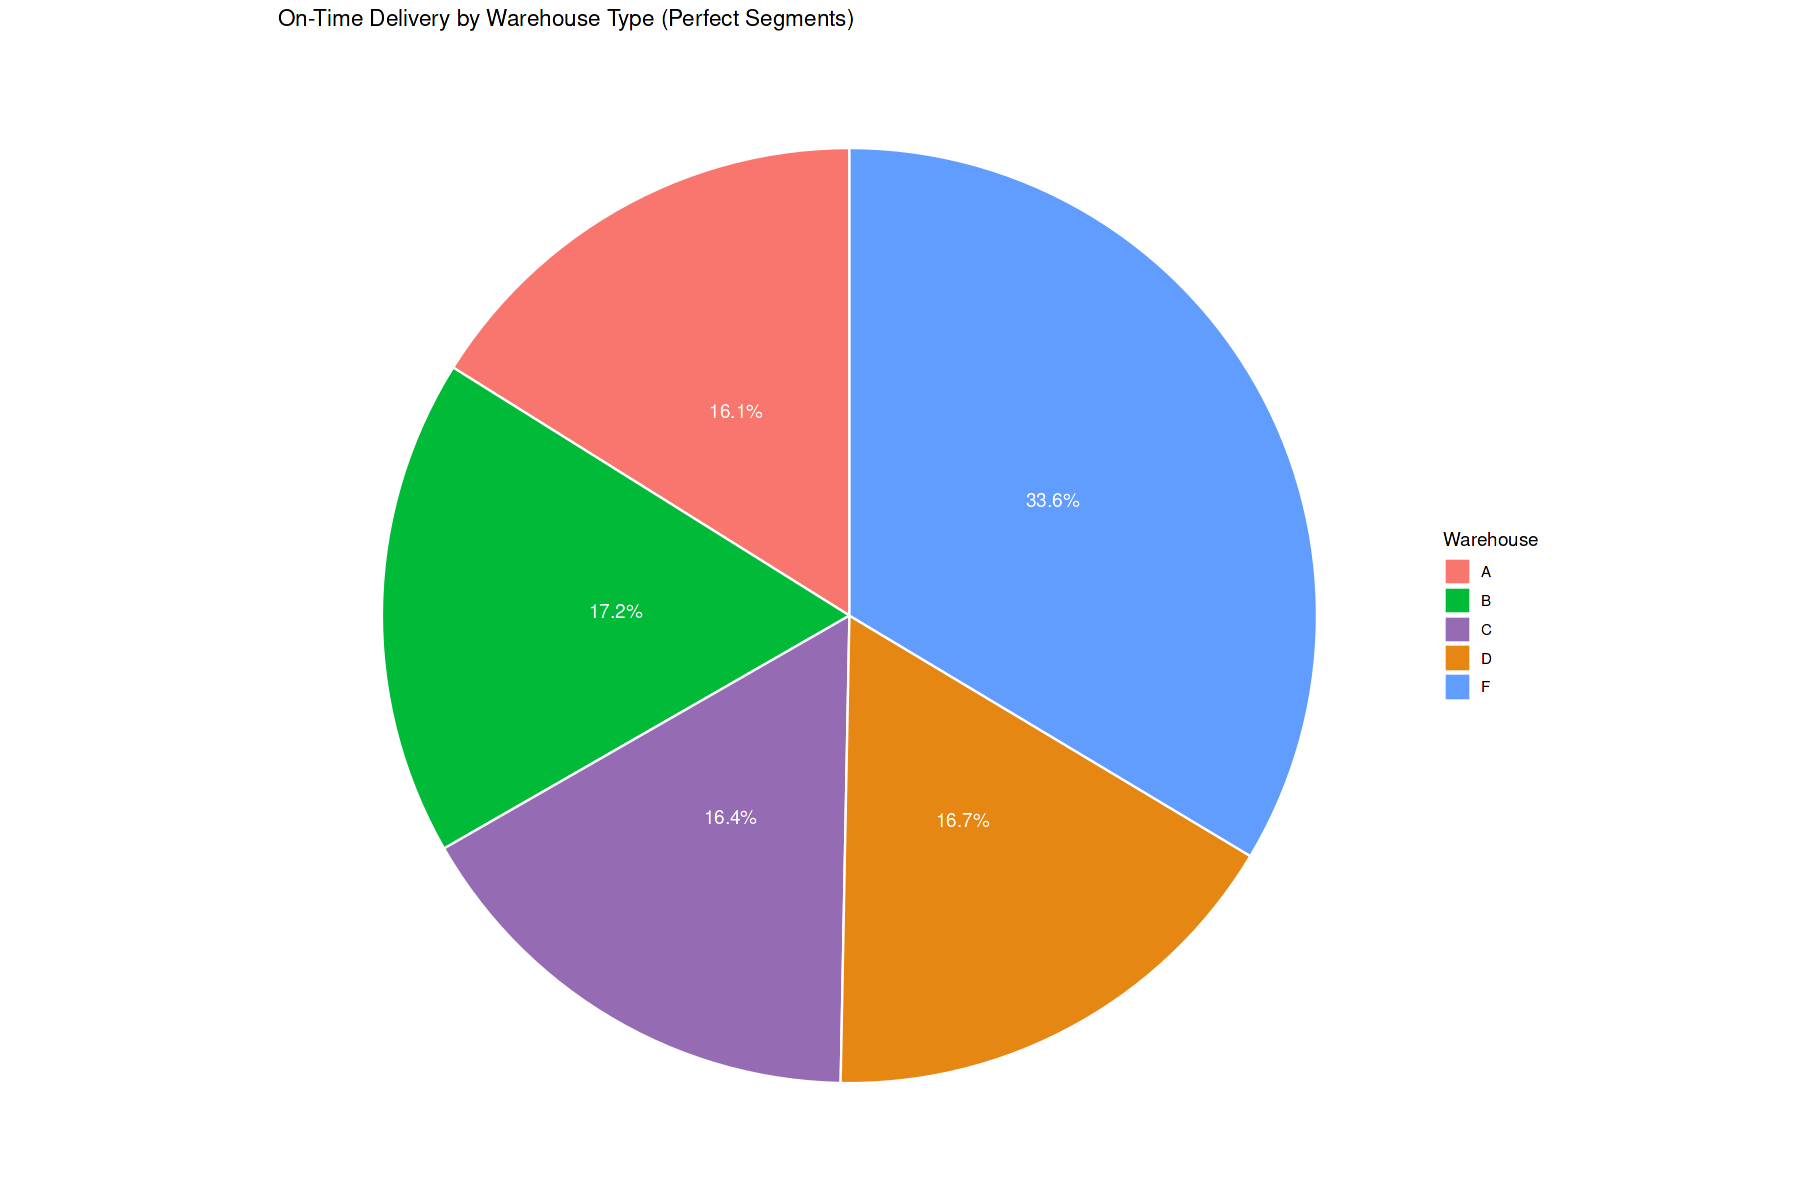

In [6]:

# 🎨 Define the color palette for all 5 warehouse types
warehouse_colors <- c(
  "A" = "#F8766D",
  "B" = "#00BA38",
  "F" = "#619CFF",
  "D" = "#E68613",
  "C" = "#956CB4"
)

# 📊 Summarize proportions by warehouse type
warehouse_dist <- perfect_subset %>%
  group_by(warehouse_type) %>%
  summarise(count = n()) %>%
  mutate(percent = round(100 * count / sum(count), 1))

# 🧁 Pie chart
ggplot(warehouse_dist, aes(x = "", y = percent, fill = warehouse_type)) +
  geom_col(width = 1, color = "white") +
  coord_polar(theta = "y") +
  geom_text(aes(label = paste0(percent, "%")),
            position = position_stack(vjust = 0.5), color = "white") +
  scale_fill_manual(values = warehouse_colors) +
  labs(
    title = "🏬 On-Time Delivery by Warehouse Type (Perfect Segments)",
    fill = "Warehouse"
  ) +
  theme_void()

# ✅ Save plot
ggsave("on_time_delivery_by_warehouse_type.png", width = 10, height = 6, dpi = 300)


------------------------------------------------------------------------

## 8. Final Insights and Recommendations

Data analysis and modeling surfaced several high-value patterns:

### High-Performance Delivery Segments
- Products under **$175 and under 4 lbs** achieved a **96.8% on-time delivery rate**
- Products between **4.5–8 lbs** showed **0% late deliveries**
- These items clustered around select warehouses (notably Type F) and primarily used “Ship” as delivery mode

### Operational Recommendations
- **Replicate perfect conditions**: Investigate which SKUs fall into this group. Are there packaging, route, or facility advantages that can be scaled?
- **Audit high-performing warehouses**: Type F warehouses had a strong presence in the best-performing segments. Audit these facilities to identify operational best practices. Consider prioritizing their use for high-risk deliveries.
- **Validate delivery mode logic**: “Ship” shipments account for ~70% of the on time deliveries in our subset. Validate how modes (Road, Ship, Flight) are assigned and evaluate average transit times. If shipping mode correlates with geography or warehouse location, re-optimizing routing logic may improve delivery accuracy.

### Strategic Modeling Use
- Use model predictions to **flag high-risk deliveries** based on cost, weight, and discounts — deprioritize low-signal features like gender
- Employ business rules post-model to escalate high-priority customer orders, even if model confidence is high


------------------------------------------------------------------------

## 9. Next Steps

To operationalize these insights and extend model value:

- **Refine business context**  
  Collaborate with operations teams to validate routing logic, facility constraints, and packaging practices

- **Hyperparameter tuning**  
  Further optimize XGBoost or LightGBM using Optuna to improve recall on late deliveries

- **Enrich the dataset**  
  Add external signals like weather, holidays, region, or real-time delay feeds to boost model accuracy

- **Deploy a real-time dashboard**  
  Use Tableau, Streamlit, or Power BI to surface predicted late deliveries and monitor impact

- **Test model-driven routing decisions**  
  Run A/B tests or operational pilots to evaluate the real-world business impact of acting on predictions
  
------------------------------------------------------------------------  
  
## 10. Project Files & Portfolio Links

GitHub Repository: [github.com/yourusername/supply-chain-delivery](#)  
Google Colab Notebook: [View in Colab](https://colab.research.google.com/drive/1FVgIY6qvmbH7W0Zrpdu1KYgv2V9KvMJ5?usp=sharing)  
R Markdown Report (HTML): [View HTML](#)  
Key Visuals: [product_cost_vs_weight.png](#), [warehouse_type_pie.png](#)

---

This project demonstrates applied analytics across the full pipeline — from data cleaning and EDA in R to modeling, segmentation, and operational recommendations using Python and visualization tools. For recruiters or teams reviewing this case study, I’m happy to walk through the notebook and share additional insights.